## Création d'un classificateur pour déterminer le type de pneu utilisé pendant un relais
En Formule 1, cinq types de pneus peuvent être utilisés pendant une course : 
<ul>
    <li> Soft : ce pneu, extrêmement rapide, possède la durée de vie la plus courte.</li>
    <li> Medium : ce pneu est moyennement rapide et possède une durée de vie moyenne.</li>
    <li> Hard : ce pneu est le plus lent mais le plus durable.</li>
    <li> Inter : ce pneu est conçu pour être utilisé sur circuit humide.</li>
    <li> Wet : ce pneu est utilisé dans le cas d'un circuit trempé, c'est le plus lent de tous.</li>
</ul>
Nous n'avons pas de labels à notre disposition pour entraîner un modèle de manière supervisée. Il s'agit d'un problème <b>d'apprentissage non supervisé</b>.

Il est raisonnable de penser que réussir à classifier les pneus dans ce scénario est hors de portée pour des étudiants de L3 : nous allons donc utiliser un ensemble d'apprentissage très restreint, ne contenant que les données de pneus pour une saison, recueillies à la main.

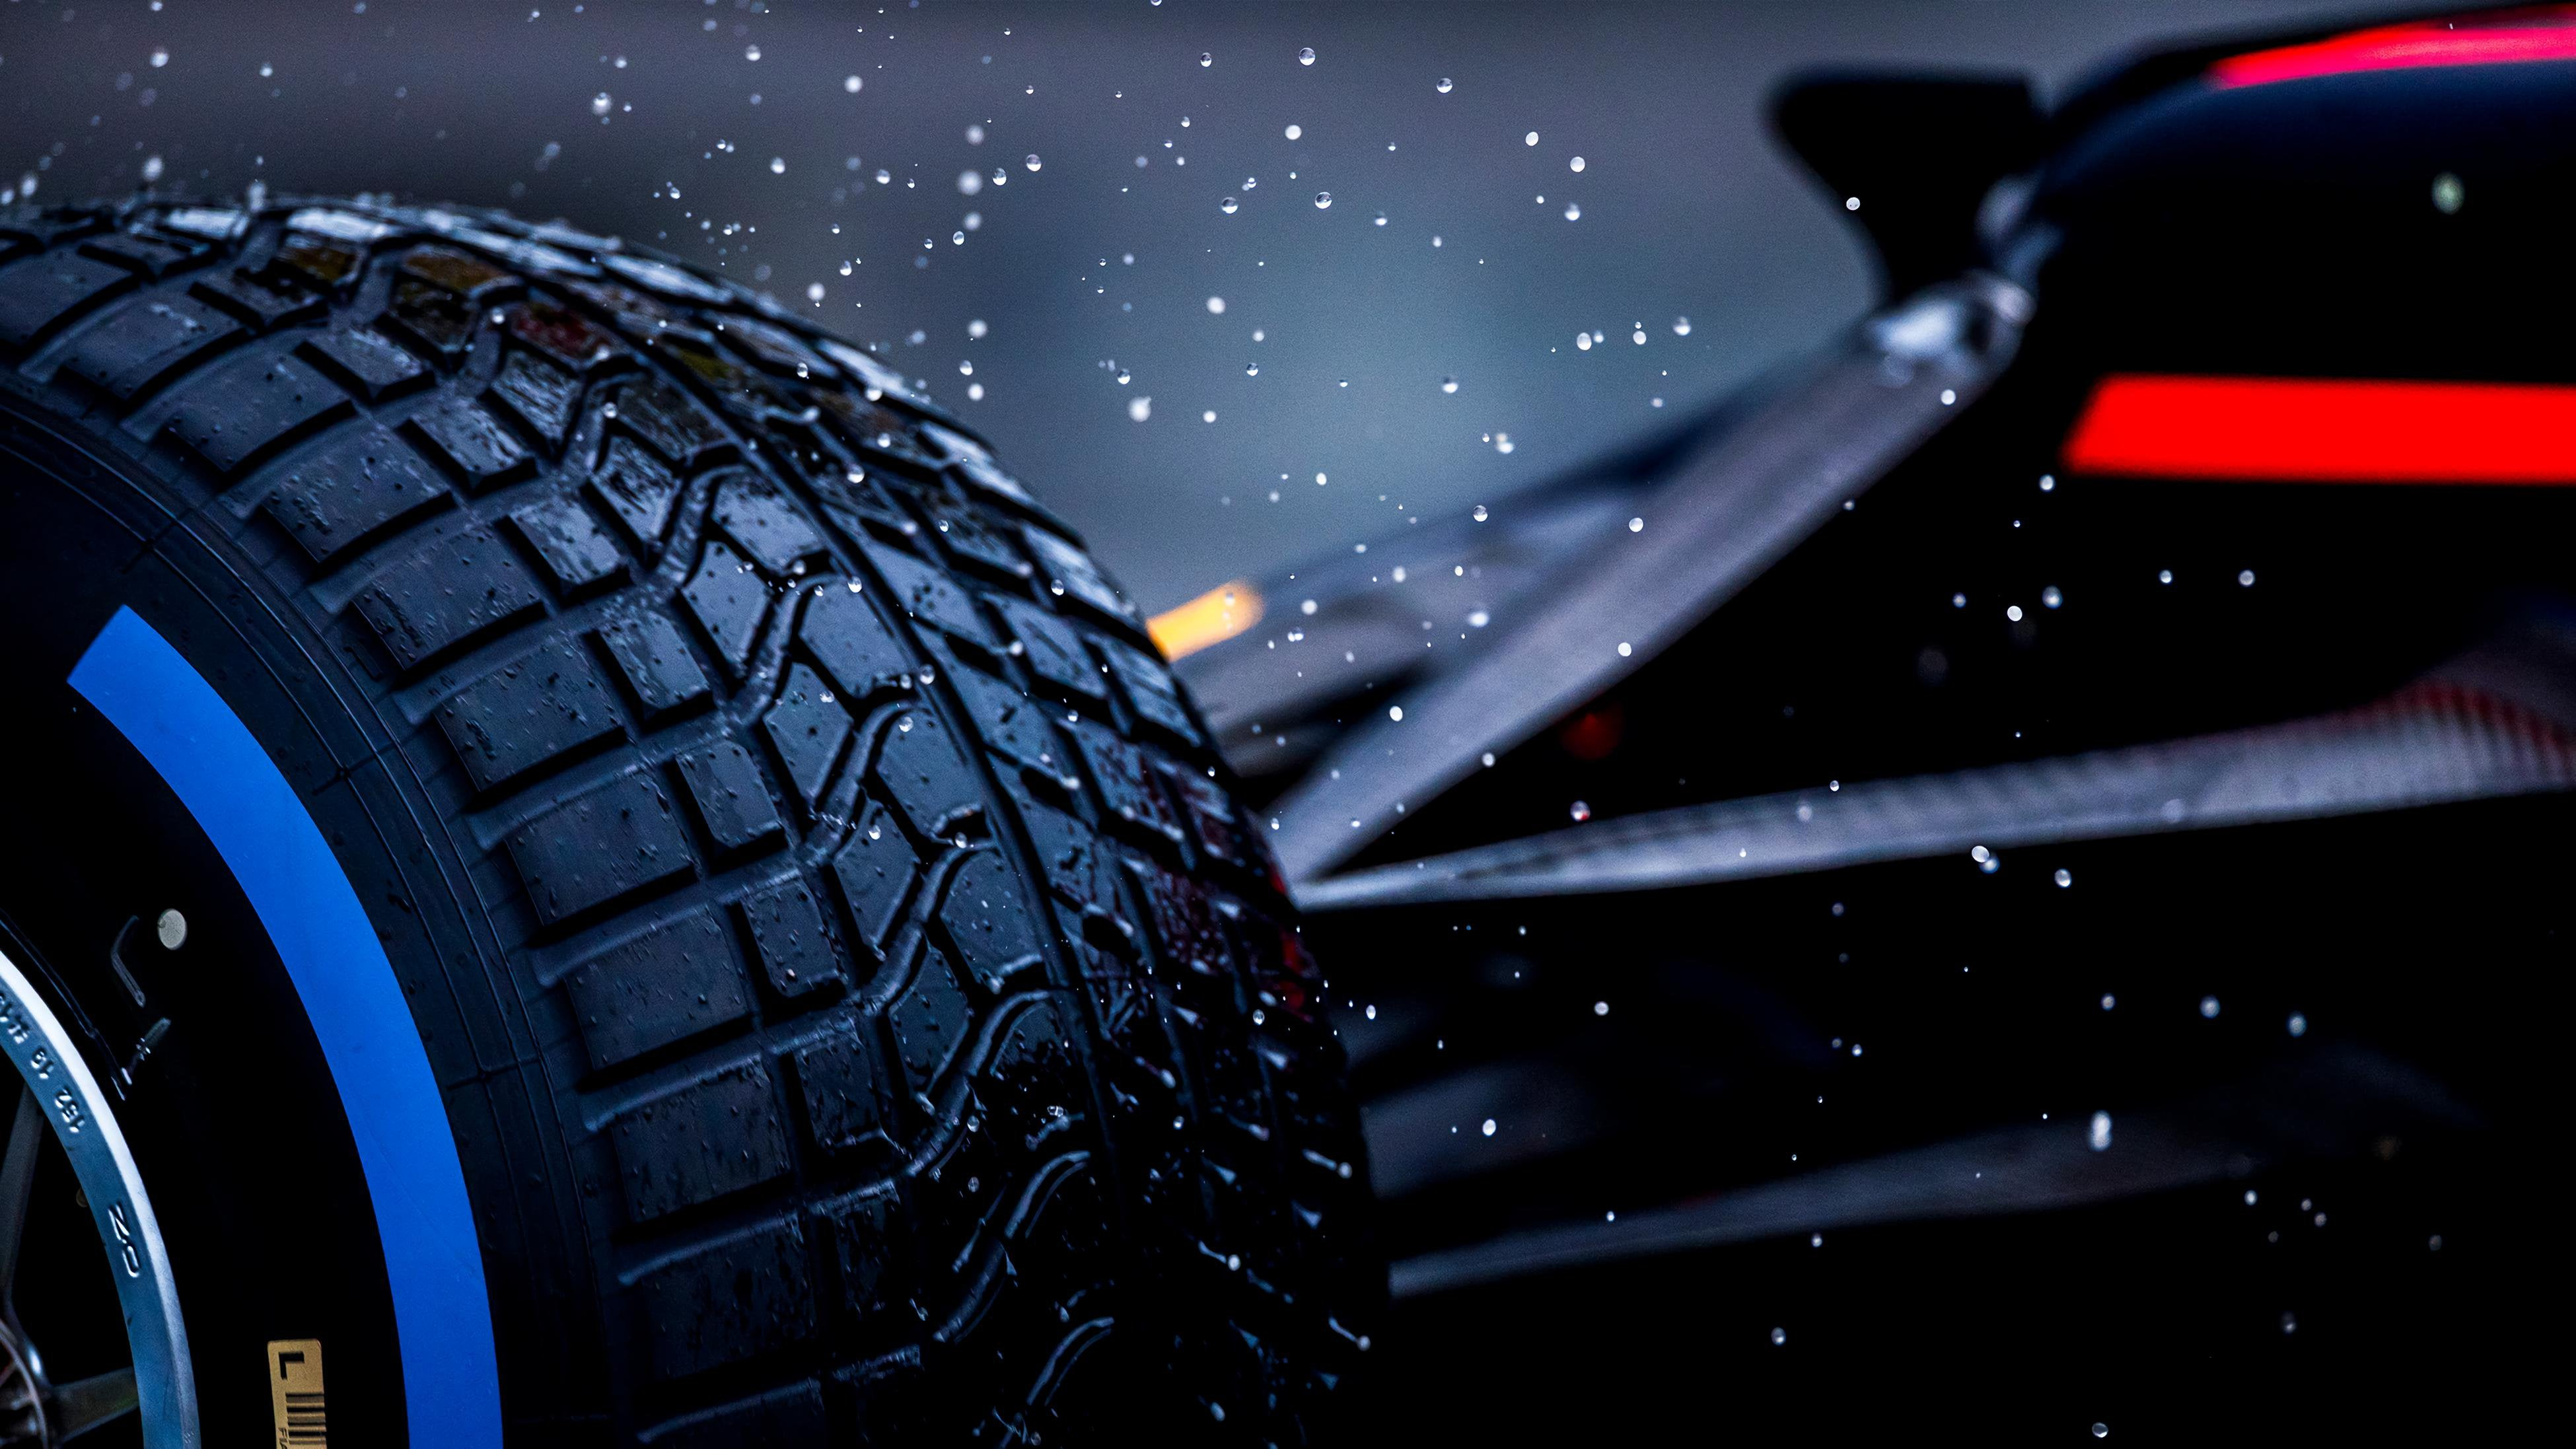

### Intuitions pour développer le modèle

L'objectif est de trouver, pendant une course et pour un pilote donné, quels composés de pneus il a utilisé.
La différence entre deux composés de pneus peut être observée sur deux plans : la durée du relais (longévité du pneu) et le temps au tour (adhérence du pneu).

Il convient de prendre en compte les considérations suivantes : 

- Un pilote Williams ayant chaussé des <i>softs</i> peut avoir, au même moment de la course, un temps au tour supérieur à un pilote Ferrari équipé de <i>hards</i> en raison de la différence de puissance entre les deux monoplaces. Pour modéliser ce phénomène, on peut réutiliser les coefficients de puissance et de forme introduits dans la partie régression linéaire de ce projet.

- Au fur et à mesure de l'avancement de la course, les voitures s'allègent en raison de la diminution de la masse d'essence dans le réservoir : c'est pourquoi le <i>Meilleur tour</i> est très souvent obtenu en fin de course : on peut donc prendre en compte le nombre de tours, sous forme de pourcentage, pour classifier pneus.

- Naturellement,un temps au tour ne peut être représentatif que pour un circuit donné : c'est pour cela qu'il conviendra de stocker l'identifiant du circuit sous forme de one-hot.

Notre dataset sera de la forme suivante:

| circuitId | constructorPower | constructorForm | race_completion | stint_duration | stint_avg_laptime | compound |


En fait l'histoire est plus complexe : Pirelli, le fabricant de pneus officiel de la Formule 1, propose une gamme de 5 composés de pneus pour la saison. Ils possèdent chacun un identifiant, qui s'étend de C1 (gomme la plus dure) à C5 (gomme la plus molle).

Chaque weekend, trois composés sont sélectionnés parmi les 5 disponibles et sont affublés des noms <i>soft, medium et hard</i>. Ainsi, si le choix de pneus est $(C1,C2,C3)$ pour un weekend $w_1$ et $(C3,C4,C5)$ pour un weekend $w_2$, le pneu _soft_ de $w_1$ est exactement le même composé que le _hard_ de $w_2$ !

C'est pourquoi nous devrons associer, pour chaque course, aux pneus leur composé exact et procéder à une classification en cinq classses et non pas trois comme l'intuition nous le suggèrerait.

In [351]:
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

sns.set()
sns.set_style("white")
# mpl.rcParams['figure.figsize'] = (12, 10)

In [352]:
tyres = pd.read_csv("datasets/tyres.csv")
constructorResults = pd.read_csv("datasets/constructor_results.csv", index_col=0)
constructors = pd.read_csv("datasets/constructors.csv", index_col=0)
constructorStandings = pd.read_csv("datasets/constructor_standings.csv", index_col=0)
drivers = pd.read_csv("datasets/drivers.csv", index_col=0)
lapTimes = pd.read_csv("datasets/lap_times.csv")
pitStops = pd.read_csv("datasets/pit_stops.csv")
qualifying = pd.read_csv("datasets/qualifying.csv", index_col=0)
races = pd.read_csv("datasets/races.csv",index_col=0)
results = pd.read_csv("datasets/results.csv", index_col=0)
status = pd.read_csv("datasets/status.csv", index_col=0)
races = races.reindex(np.random.permutation(races.index))
resume = pd.read_csv("final_dataset.csv")

In [387]:
'''
Ce dictionnaire associe à chaque course de la saison 2019 le choix de pneus effectué par 
Pirelli (données recueillies à la main).
'''
tyre_compound_selection = {1010:[4,3,2], #Australia
                           1011:[3,2,1], #Bahrain
                           1012:[4,3,2], #China
                           1013:[4,3,2], #Azerbaijan
                           1014:[3,2,1], #Spain
                           1015:[5,4,3], #Monaco
                           1016:[5,4,3], #Canada
                           1017:[4,3,2], #France
                           1018:[4,3,2], #Austria
                           1019:[3,2,1], #Great Britain
                           1020:[4,3,2], #Germany (cette course s'est déroulée sous la pluie)
                           1021:[4,3,2], #Hungary
                           1022:[3,2,1], #Belgium
                           1023:[4,3,2], #Italia
                           1024:[5,4,3], #Singapore
                           1025:[4,3,2], #Russia
                           1026:[3,2,1], #Japan
                           1027:[4,3,2], #Mexico
                           1028:[4,3,2], #USA
                           1029:[3,2,1], #Brazil
                           1030:[5,4,3], #Abu Dhabi
                          }

In [354]:
def getDriverName(driverId):
    '''
    In : driverId (int) : numéro d'identification du pilote
    Out : nom et prénom du pilote (string)
    '''
    try:
        name = str(drivers['forename'].loc[driverId])+' '+str(drivers['surname'].loc[driverId])
        return name
    except UnicodeDecodeError:
        return driverRef

def getDriverId(forename, surname):
    '''
    In : prénom (string) et nom (string)
    Out : driverId (int)
    '''
    return drivers.index[(drivers['forename'] == forename) & (drivers['surname'] == surname)].tolist()[0]

def getConstructorId(constructor):
    '''
    In : constructor (string) : exemple, "McLaren" ou "Ferrari"
    Out : constructorId (int)
    '''
    return constructors.index[constructors['name'] == constructor].tolist()[0]

def getConstructorName(id):
    '''
    In : constructorId (int)
    Out : nom du constructeur (string)
    '''
    return str(constructors['name'].loc[id])

def getDriversInRace(raceId):
    '''
    In : raceId (int)
    Out : les id des pilotes ayant participé à la course (list(int))
    '''
    drivers = results[results['raceId'] == raceId]
    drivers = drivers['driverId']
    return drivers.tolist()


In [355]:
def getInformation(raceId, driverId):
    '''
    Cette fonction permet d'exécuter quelques lignes de code fastidieuses.
    In : raceId (int)
         driverId (int)
    Out : 6 DataFrames correspondant à l'union de chaque DataFrame importé avec le numéro de course et le numéro de pilote.
    '''
    try:
        race = races.loc[raceId] #Find the race
        driver = drivers.loc[driverId] #Find the driver
        result = results[(results['raceId'] == raceId) & (results['driverId'] == driverId)].iloc[0]
        pits = pitStops[(pitStops['raceId'] == raceId) & (pitStops['driverId'] == driverId)]
        quali = qualifying[(qualifying['raceId'] == raceId) & (qualifying['driverId'] == driverId)]
        laps = lapTimes[(lapTimes['raceId'] == raceId) & (lapTimes['driverId'] == driverId)]
        return(race,driver,result,pits,quali,laps)
    except Exception: #Si on a entré un mauvais couple (raceId, driverId)
        print('Impossible de trouver la course n°{}'.format(raceId))
        return getInformation(raceId-1,driverId)


def getQualifyingPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : le résultat de qualifications du pilote (pas forcément égal à la position sur la grille, il peut 
          y avoir des pénalités) (int)    
    '''
    quali = getInformation(raceId,driverId)[4]
    if not quali.empty:
        return quali['position'].iloc[0]
    else :
        return 'Inconnu'
    
def getFastestLapTime(raceId):
    '''
    In : raceId (int)
    Out : le temps en millisecondes du tour de course le plus rapide (int)
    '''
    result = results[results['raceId'] == raceId]
    mylap = result['fastestLapTime'].min()
    minutes = int(mylap.split(":")[0])
    seconds = int(mylap.split(":")[1].split(".")[0])
    milliseconds = int(mylap.split(":")[1].split(".")[1])
    return (60000*minutes+1000*seconds+milliseconds)

def getQualifyingTime(raceId,driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : le temps en millisecondes du tour de qualifications le plus rapide (int)
    '''
    try:
        quali = qualifying[(qualifying['raceId'] == raceId) & (qualifying['driverId'] == driverId)]
        quali = quali.fillna(value='9:99.999')
        quali = quali.iloc[0]
        mylap = quali[['q1','q2','q3']]
        mylap = mylap.min()
        minutes = int(mylap.split(":")[0])
        seconds = int(mylap.split(":")[1].split(".")[0])
        milliseconds = int(mylap.split(":")[1].split(".")[1])
        return (60000*minutes+1000*seconds+milliseconds)
    except Exception: #Le pilote n'a pas participé aux qualifications (exemple Albon à Shanghai 2019)
        return getQualifyingTime(raceId, getTeammate(raceId,driverId)) #On retourne le temps de qualifications de son coéquipier.

def getComparison(raceId,driver1,driver2):
    '''
    Cette fonction d'affichage imprime un head-to-head entre deux pilotes passés en paramètres.
    On trace la comparaison de la position ainsi que la comparaison des temps au tour.
    In : raceId (int)
         driver1 (int)
         driver2 (int)
    '''
    (race,driver,result,pits,quali,laps) =getInformation(raceId,driver1)
    (race2,driver2,result2,pits2,quali2,laps2) =getInformation(raceId,driver2)
    if not laps.empty and not laps2.empty:
        fig = plt.figure(figsize=(14,5),dpi=300)
        ax2 = fig.add_subplot(121)
        l1, = ax2.plot(laps['lap'].tolist(), laps['milliseconds'].tolist(), 'blue')
        l2, = ax2.plot(laps2['lap'].tolist(), laps2['milliseconds'].tolist(), 'red')
        ax2.set_ylabel('milliseconds')
        l1.set_label(getDriverName(driver1))
        l2.set_label(getDriverName(driver2.name))
        ax2.legend()
        ax2.title.set_text('Comparaison des temps au tour')
        
        ax1 = fig.add_subplot(122)
        ax1.set_ylabel('position')
        plt.gca().invert_yaxis()
#         plt.fill_between(laps['lap'], laps['position'],color="blue", alpha=0.1)
#         plt.fill_between(laps2['lap'], laps2['position'],color="red", alpha=0.1)
        l3, = ax1.plot(laps['lap'].tolist(), laps['position'].tolist(),color='blue')
        l3.set_label(getDriverName(driver1))
        l4, = ax1.plot(laps2['lap'].tolist(), laps2['position'].tolist(),color='red')
        l4.set_label(getDriverName(driver2.name))
        ax1.legend()
        ax1.title.set_text('Comparaison de la position')
        plt.tight_layout()
    else:
        print('Comparaison non disponible')
        
def getTeammate(raceId,driverId):
    result = results[results['raceId'] == raceId]
    constructor = result[result['driverId'] == driverId]['constructorId'].iloc[0]
    current_round = races['round'].loc[raceId]
    try:
        teammate = result[(results['constructorId'] == constructor) & (results['driverId'] != driverId)]['driverId'].iloc[0]
    except Exception:
        if current_round > 1: #Si ce n'est pas la première course de la saison, on retourne l'équipier de la course précédente
            return getTeammate(raceId-1, driverId)
        else:
            return getTeammate(raceId+1, driverId)
    return teammate

In [356]:
def getWCCPoints(year,constructorId):
    '''
    In : year (int)
         constructorId (int)
    Out : le nombre de points au championnat constructeurs en fin de saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings[constructorStandings['constructorId'] == constructorId]
        standings = standings.merge(myRaces,right_index=True,left_on='raceId')
        return standings['points'].iloc[standings.shape[0]-1]
    except Exception:
        print('Impossible de retrouver les points')

def getWCCResult(year, constructorId):
    '''
    In : year (int)
         constructorId (int)
    Out : le classement au championnat constructeur en fin de saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == standings['round'].max()]
        standings = standings[standings['constructorId'] == constructorId]
    #     print("L'équipe "+getConstructorName(constructorId)+'('+str(constructorId)+')'+" a terminé "+str(standings['position'].tolist()[0])+"e")
        return standings['position'].tolist()[0]
    except Exception:
        return 5
    
def getWCCPosition(year, myround, constructorId):
    '''
    In : year (int)
         myround (int) : numéro de la course dans la saison
         constructorId (int)
    Out : la position au championnat constructeurs à un moment donné de la saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == myround]
        standings = standings[standings['constructorId'] == constructorId]
        return standings['position'].tolist()[0]
    except Exception:
        return 5 #Si c'est la première course de la saison, on simule toutes les écuries comme égales.
    
    
def getWCCStandings(year):
    '''
    In : year (int)
    Out : le classement constructeurs de cette année (DataFrame)
    '''
    myRaces = races[races['year'] == year].sort_values('round')
    standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
    standings = standings[standings['round'] == standings['round'].max()]
    return standings[['constructorId','position']].sort_values('position',ascending=True)

    

In [357]:
def getStints(raceId,driverId):
    '''
    Cette fonction donne les différents relais effectués par un pilote pendant une course (tous deux
    passés en paramètre).
    L'intuition nous suggère de prendre, pour chaque relais, la moyenne du temps au tour.
    Plutôt , on prend le rapport du temps moyen au tour d'un relais avec le tour le plus rapide de ce
    pilote en qualifications (donc sur le pneu le plus tendre).
    Cela nous permet de retirer l'aspect de différence de puissance entre les voitures puisqu'on compare un pilote 
    avec sa propre performance.
    In : raceId (int)
         driverId (int)
    Out : stintDf (DataFrame) qui comporte les features de chaque relais pour ce pilote.
    '''
    #On crée le DataFrame qu'on va retourner
    stintDf = pd.DataFrame(columns=['circuitId','driverId','constructorId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
    
    #On récupère les informations de course
    (race,driver,result,pits,quali,laps) = getInformation(raceId, driverId)
    
    #On récupère le composé de pneus de cette course pour le pilote
    tyre = tyres[(tyres['raceId'] == raceId) & (tyres['driverId'] == driverId)]
    
    #On récupère l'année, le constructeur, le circuit, le round, 
    #le tour le plus rapide en qualifications et en course
    year = race['year']
    current_round = race['round']
    qualifyingTimes = getQualifyingTime(raceId, driverId)
    fastestLap = getFastestLapTime(raceId)
    circuit = int(race['circuitId'])
    constructor = int(result['constructorId'])
    
    #On associe à chaque tour son rapport avec le temps de qualifications.
    #Le modèle marche moins bien si on fait cela, donc on ne l'utilise pas pour l'instant.
#     laps['milliseconds'] = laps['milliseconds']/qualifyingTimes
    
    #On crée les coefficients de forme et de puissance.
    power = 1.0/np.power(np.tan(0.1*getWCCResult(year-1,result['constructorId'])),0.7)
    form = 1.0/np.power(np.tan(0.1*getWCCPosition(year,current_round,result['constructorId'])),0.7)
    
    #On retrouve les informations de pit-stop
    race_duration = laps.shape[0]
    pit_laps = pits['lap']
    nb_pits = 0
    laps2 = {0:[]}
    stints = {0:[]}
    for i in range(1,race_duration):
        try:
            if i < pit_laps.iloc[nb_pits]: #Tant qu'un pilote est entre deux pit-stops
                laps2[nb_pits].append(laps['lap'].iloc[i])
                stints[nb_pits].append(laps['milliseconds'].iloc[i])
            elif i == pit_laps.iloc[nb_pits]: #Quand un pilote rentre dans la pitlane
                laps2[nb_pits].append(laps['lap'].iloc[i])
                stints[nb_pits].append(laps['milliseconds'].iloc[i])
                nb_pits += 1
                stints[nb_pits] = []
                laps2[nb_pits] = []
        except IndexError :
            laps2[nb_pits].append(laps['lap'].iloc[i])
            stints[nb_pits].append(laps['milliseconds'].iloc[i])
    for key in stints.keys():
        gap = max(laps2[key])-min(laps2[key])+1 #La durée en tours de ce relais
        stints[key] = np.mean(stints[key]) #La moyenne des rapports des temps au tour
        laps2[key] = np.mean(laps2[key]) #A quel moment de la course ce relais a-t-il eu lieu ?
        compound = tyre[tyre['nbStops'] == key]
#         print(compound)
        mycompound = compound['compound'].iloc[0]
        stintDf = stintDf.append({'circuitId':circuit,'driverId':driverId, 'constructorId':constructor,'constructorPower':power,'constructorForm':form,'race_completion':laps2[key],'stint_duration':(1.0*gap/race_duration),'stint_avg_laptime':stints[key],'compound':mycompound}, ignore_index=True)
    return stintDf

In [358]:
mystints = getStints(1014,817)
display(mystints)

,circuitId,driverId,constructorId,constructorPower,constructorForm,race_completion,stint_duration,stint_avg_laptime,compound
0,4.0,817.0,4.0,1.826882,0.979762,13.5,0.363636,85477.958333,1.0
1,4.0,817.0,4.0,1.826882,0.979762,36.0,0.318182,87210.285714,3.0
2,4.0,817.0,4.0,1.826882,0.979762,56.5,0.303030,90427.900000,2.0


In [423]:
def prepare_stint_dataset(raceId):
    dataframe = pd.DataFrame(columns=['circuitId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
    drivers = getDriversInRace(raceId)
    for driver in drivers:
        print('{} : {}\r'.format(driver,getDriverName(driver))),
#         time.sleep(0.25)
        dataframe = dataframe.append(getStints(raceId, driver))
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop('index', axis=1)
    mycompounds = tyre_compound_selection[raceId]
#     for i in range(0,len(mycompounds)):
#         dataframe['compound'] = np.where(dataframe['compound'] == i+1, mycompounds[i],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 3,mycompounds[0],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 2,mycompounds[1],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 1,mycompounds[2],dataframe['compound'])
    dataframe['driverPerformance'] = resume['driverPerformance']
    return dataframe

In [424]:
df = prepare_stint_dataset(1014)
# df = df[df['stint_duration'] >= 10]
df.head()

,circuitId,compound,constructorForm,constructorId,constructorPower,driverId,race_completion,stint_avg_laptime,stint_duration,driverPerformance
0,4.0,1.0,5.000164,131.0,5.000164,1.0,15.0,83227.259259,0.409091,1.771561
1,4.0,2.0,5.000164,131.0,5.000164,1.0,38.0,86427.421053,0.287879,1.464100
2,4.0,1.0,5.000164,131.0,5.000164,1.0,57.0,93408.000000,0.287879,2.593742
3,4.0,1.0,5.000164,131.0,5.000164,822.0,14.5,83596.076923,0.393939,5.054470
4,4.0,2.0,5.000164,131.0,5.000164,822.0,37.0,84507.263158,0.287879,0.564474


In [426]:
data = pd.DataFrame(columns=['circuitId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
for i in range(1010,1019):
    print(i)
    data = data.append(prepare_stint_dataset(i))
data = data.reset_index()
data['stint_avg_laptime'] = (data['stint_avg_laptime'] - data['stint_avg_laptime'].mean()) / data['stint_avg_laptime'].std()
data['stint_duration'] = (data['stint_duration'] - data['stint_duration'].mean()) / data['stint_duration'].std()
data['race_completion'] = (data['race_completion'] - data['race_completion'].mean()) / data['race_completion'].std()

display(data.head())
display(data.describe())

1010
1011: Carlos Sainzardozi
1012: Romain Grosjeanozi
1013: Nico Hülkenbergzzi
1014: Daniel Ricciardozi
1015: Lando Norrisllazzi
1016: Charles Leclerczzi
1017: Lando Norrisbonzzi
1018: Romain Grosjeanzzi


,index,circuitId,compound,constructorForm,constructorId,constructorPower,driverId,driverPerformance,race_completion,stint_avg_laptime,stint_duration
0,0,1.0,2.0,5.000164,131.0,5.000164,822.0,1.771561,-0.878251,-0.210585,-0.058554
1,1,1.0,3.0,5.000164,131.0,5.000164,822.0,1.464100,0.751198,-0.375085,0.853332
2,2,1.0,2.0,5.000164,131.0,5.000164,1.0,2.593742,-1.106945,-0.126734,-0.721744
3,3,1.0,3.0,5.000164,131.0,5.000164,1.0,5.054470,0.522504,-0.336798,1.516523
4,4,1.0,2.0,2.273518,9.0,2.273518,830.0,0.564474,-0.821077,-0.173369,0.107243


,index,circuitId,compound,constructorForm,constructorId,constructorPower,driverId,driverPerformance,race_completion,stint_avg_laptime,stint_duration
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,4.320000e+02,4.320000e+02,4.320000e+02
mean,24.041667,22.673611,2.798611,1.872292,62.164352,1.967490,627.696759,1.285041,5.139921e-19,6.368363e-15,2.301657e-15
std,14.828740,26.601423,1.137302,1.262184,82.395111,1.212993,349.775570,0.915390,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,1.000000,1.000000,0.733362,1.000000,0.733362,1.000000,0.197845,-1.507161e+00,-1.896624e+00,-1.903584e+00
25%,11.750000,4.000000,2.000000,0.979762,4.000000,1.304367,154.000000,0.620921,-9.068374e-01,-7.206206e-01,-6.276706e-01
50%,23.500000,7.000000,3.000000,1.304367,6.000000,1.526851,825.000000,1.048809,-1.349933e-01,4.741234e-02,-1.508378e-01
75%,35.250000,34.000000,4.000000,2.273518,131.000000,2.273518,842.000000,1.610510,8.726920e-01,6.580189e-01,5.665185e-01
max,59.000000,73.000000,5.000000,5.000164,211.000000,5.000164,848.000000,5.054470,2.437820e+00,4.250242e+00,2.716374e+00


Text(0.5,0.98,'Temps moyen au tour par compose')

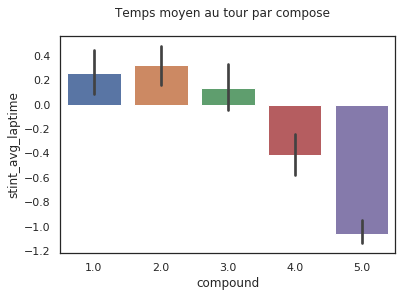

In [514]:
sns.barplot(data['compound'], data['stint_avg_laptime'])
plt.suptitle("Temps moyen au tour par compose")

Text(0.5,0.98,'Duree moyenne du relais par compose')

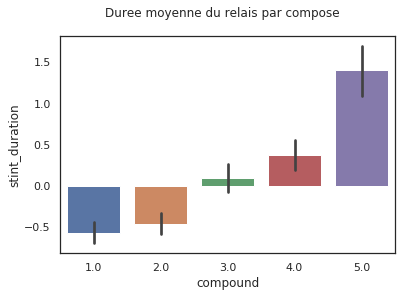

In [515]:
sns.barplot(data['compound'], data['stint_duration'])
plt.suptitle("Duree moyenne du relais par compose")

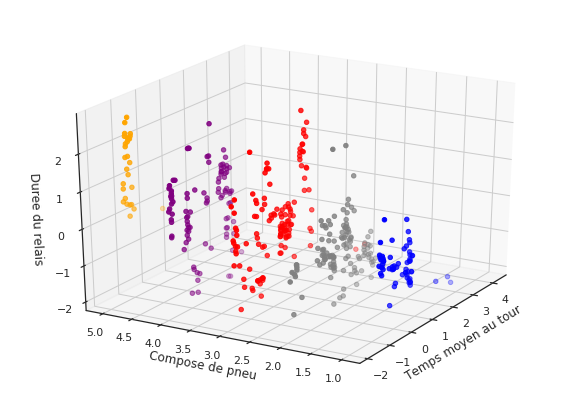

In [507]:
%matplotlib inline
#matplotlib notebook + restart Kernel pour faire tourner le graphique
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111, projection='3d')
data1= data[data['compound'] == 1.0]
data2= data[data['compound'] == 2.0]
data3= data[data['compound'] == 3.0]
data4= data[data['compound'] == 4.0]
data5= data[data['compound'] == 5.0]
# Data for three-dimensional scattered points
zdata1 = data1['stint_duration']
xdata1 = data1['stint_avg_laptime']
ydata1 = data1['compound']
ax1.scatter3D(xdata1, ydata1, zdata1, color='blue');

zdata2 = data2['stint_duration']
xdata2 = data2['stint_avg_laptime']
ydata2 = data2['compound']
ax1.scatter3D(xdata2, ydata2, zdata2, color='grey');

zdata3 = data3['stint_duration']
xdata3 = data3['stint_avg_laptime']
ydata3 = data3['compound']
ax1.scatter3D(xdata3, ydata3, zdata3, color='red');

zdata4 = data4['stint_duration']
xdata4 = data4['stint_avg_laptime']
ydata4 = data4['compound']
ax1.scatter3D(xdata4, ydata4, zdata4, color='purple');

zdata5 = data5['stint_duration']
xdata5 = data5['stint_avg_laptime']
ydata5 = data5['compound']
ax1.scatter3D(xdata5, ydata5, zdata5, color='orange');

ax1.set_xlabel('Temps moyen au tour')
ax1.set_ylabel('Compose de pneu')
ax1.set_zlabel('Duree du relais')
ax1.view_init(elev=25., azim=210)
fig.show()

Comme on peut le voir sur le graphique 3D, il n'y  pas grand chose à prédire. Nous allons tout de même faire de notre mieux.

In [509]:
#On shuffle le dataframe.
date= data.reindex(np.random.permutation(data.index))
#On crée les ensembles d'entraînement et de test.
train_tyre = date.sample(frac=0.7,random_state=1)
test_tyre = date.drop(train_tyre.index)
train_tyre = train_tyre[['constructorForm', 'circuitId', 'compound', 'constructorPower', 'driverPerformance', 'race_completion', 'stint_avg_laptime', 'stint_duration']]
test_tyre = test_tyre[['constructorForm', 'circuitId', 'compound', 'constructorPower', 'driverPerformance', 'race_completion', 'stint_avg_laptime', 'stint_duration']]

In [510]:
#Création des labels
train_tyre_label = train_tyre.pop('compound')
test_tyre_label = test_tyre.pop('compound')
#On transforme le circuitId en one-hot.
train_tyre['circuitId'] = pd.Categorical(train_tyre['circuitId'])
train_tyre = pd.get_dummies(train_tyre)
test_tyre['circuitId'] = pd.Categorical(test_tyre['circuitId'])
test_tyre = pd.get_dummies(test_tyre)

In [446]:
circuits_1hot = train_tyre[['circuitId_1.0','circuitId_3.0','circuitId_4.0','circuitId_6.0','circuitId_7.0','circuitId_17.0','circuitId_34.0','circuitId_70.0','circuitId_73.0']]

In [447]:
'''
On transforme les DataFrame en tableaux numpy pour pouvoir prédire avec le Random Forest.
'''
tr = train_tyre.to_numpy()
tr_l = train_tyre_label.to_numpy()
te = test_tyre.to_numpy()
te_l = test_tyre_label.to_numpy()

In [448]:
#On initialise le modèle de RandomForest.
from randomForest import RandomForest
#Creation d'une random forest de 111 arbres, 3 features par coupe et 2 éléments minimum par coupe
myforest = RandomForest(111,3,2)
myforest.build_forest(tr, tr_l)

-----------------------------------------------------------------------------------------------------------------------------------------------------
[3. 2. 3.]
3
[4. 3. 4.]
3
[3. 3. 4.]
3
[3. 4. 4. 4. 4.]
5
[2. 4. 2.]
3
[4. 5. 4. 5. 4.]
5
[5. 5. 5.]
3
[2. 3. 2. 2. 2.]
5
[2. 2. 4. 4.]
4
[3. 3. 3. 3. 3. 3. 3.]
7
[2. 2. 2. 2.]
4
[2. 4. 2.]
3
[2. 2. 2.]
3
[2. 1. 1. 2.]
4
[2. 2. 2. 2.]
4
[3. 3. 2. 1. 1.]
5
[2. 3. 3.]
3
[2. 2. 2.]
3
[1. 3. 1. 1. 1.]
5
[1. 1. 2. 1.]
4
[2. 1. 2.]
3
[1. 1. 1.]
3
[2. 1. 1. 1.]
4
[1. 1. 2. 1.]
4
[5. 5. 5.]
3
[3. 4. 3. 3. 4. 3.]
6
[4. 4. 4.]
3
[4. 4. 4. 3. 4. 3.]
6
[3. 3. 3. 3. 3.]
5
[3. 3. 3. 4.]
4
[3. 3. 3.]
3
[2. 2. 1. 1.]
4
[1. 1. 1. 1. 1. 1.]
6
[2. 2. 2. 2. 2. 2. 2.]
7
[1. 1. 1. 1. 1.]
5
[2. 2. 2. 2. 2.]
5
[2. 1. 1.]
3
[2. 1. 1. 2. 1.]
5
[1. 1. 2. 2. 1.]
5
[1. 2. 2.]
3
[3. 2. 2. 2.]
4
[3. 2. 3. 2.]
4
[2. 2. 2. 2. 2. 2.]
6
[2. 2. 2.]
3
[2. 4. 4. 4. 4. 4. 2. 3. 3. 4. 4. 2. 4. 3. 4. 3. 2.]
17
[4. 3. 3. 3. 4. 4. 4. 3. 4. 4. 4. 3. 4. 4. 2. 3.]
16
[2. 4. 2. 4. 4. 

[2. 2. 2.]
3
[2. 1. 2.]
3
[2. 1. 1. 2.]
4
[1. 1. 1.]
3
[5. 5. 5. 5. 5.]
5
[4. 5. 5.]
3
[3. 3. 4.]
3
[5. 5. 5. 5. 5. 5. 5.]
7
[4. 4. 4.]
3
[2. 2. 1. 4. 2. 3.]
6
[3. 3. 2. 4. 3. 3. 2.]
7
[2. 3. 3. 2. 3. 3. 3. 2. 2. 3. 2. 2. 2. 3. 3. 3. 3. 3. 3. 2. 2. 3. 2. 2.]
24
[2. 2. 4. 2. 1. 1. 1. 1. 3. 4. 2. 3. 4. 4. 3. 4. 2. 1. 1. 2. 1. 2. 1. 3.
 3. 1. 2. 1. 4. 1. 1. 3. 3. 1. 4. 4. 1. 2. 2. 1. 1. 4. 1. 4. 1. 3. 3. 3.
 4. 2. 3. 3. 3. 3. 2. 2. 2. 1.]
58
[3. 3. 2. 2.]
4
[4. 4. 2. 4. 4. 4. 3. 4. 2. 2. 4. 4. 3. 2. 4. 3. 4. 3. 4. 2. 3.]
21
[2. 2. 2. 2.]
4
[3. 3. 2. 4. 3. 3. 3. 2. 3. 4. 3. 4. 3.]
13
-----------------------------------------------------------------------------------------------------------------------------------------------------
[2. 2. 2. 2.]
4
[4. 3. 4. 2. 2.]
5
[3. 3. 3. 3. 3. 3.]
6
[2. 4. 4.]
3
[3. 4. 4.]
3
[4. 3. 2. 3.]
4
[3. 2. 2. 2.]
4
[1. 1. 2. 2.]
4
[1. 1. 1.]
3
[3. 2. 3. 1. 3.]
5
[1. 3. 1.]
3
[2. 2. 1.]
3
[1. 1. 1.]
3
[3. 1. 2. 2.]
4
[2. 2. 2. 2.]
4
[2. 2. 2. 2.]
4
[2. 1. 2.]
3


[3. 3. 3.]
3
[1. 4. 1.]
3
[3. 2. 2. 2.]
4
[4. 3. 3.]
3
[3. 3. 3.]
3
[4. 4. 4. 4.]
4
[2. 3. 3. 3. 4. 3.]
6
[4. 4. 4. 4. 4.]
5
[3. 2. 2. 2.]
4
[3. 3. 3. 4. 4.]
5
[4. 2. 2. 2. 2. 2.]
6
[2. 1. 1.]
3
[2. 2. 2.]
3
[3. 3. 2.]
3
[3. 3. 3.]
3
[4. 3. 3. 3. 3.]
5
[5. 5. 5.]
3
[2. 3. 3. 3.]
4
[2. 4. 2. 2.]
4
[3. 4. 2. 3. 4. 2. 2. 2. 5. 4.]
10
[2. 3. 1. 3. 3.]
5
[2. 2. 2.]
3
[3. 3. 3. 3. 3.]
5
[3. 3. 3. 3.]
4
[3. 3. 3. 2. 3.]
5
[4. 4. 2. 4.]
4
[5. 1. 1.]
3
[2. 1. 1.]
3
[4. 4. 4. 4. 4.]
5
[5. 5. 5. 5.]
4
[3. 5. 5.]
3
[4. 4. 2. 4. 4.]
5
[1. 1. 2. 2.]
4
[3. 2. 2. 4. 2. 4. 4. 4. 2. 2. 1. 3. 2. 4. 3. 3. 2. 4. 3. 2. 1. 4.]
22
[2. 2. 2. 1. 2. 2. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2.]
16
[4. 4. 2. 2. 3. 3.]
6
[4. 4. 4. 4. 4. 2. 1. 3. 2. 4. 3. 3. 4. 4. 4. 5. 2. 4. 4. 4. 1. 4. 3. 1.
 3. 3. 4. 4. 1. 2. 3. 2. 2. 1. 4. 2. 4. 2. 2. 3. 4. 1. 1. 4.]
44
[3. 3. 3. 3.]
4
[4. 3. 4. 2. 4. 1. 4. 4. 2. 1. 3. 2. 3. 2. 3.]
15
[3. 3. 3. 3. 3. 3. 3.]
7
[2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1.]
12
[1. 1. 1.]
3
[1. 2. 1.]
3
--------------

[4. 1. 1.]
3
[2. 3. 2. 3.]
4
[4. 4. 4. 4. 4. 4.]
6
[3. 3. 3. 3. 3.]
5
[4. 4. 5. 5. 3.]
5
[4. 4. 4. 3. 4.]
5
[3. 3. 3.]
3
[2. 3. 3. 2.]
4
[4. 3. 4.]
3
[2. 2. 2. 3.]
4
[3. 3. 3. 3. 3. 3.]
6
[2. 2. 2. 2. 2. 2. 2. 2. 2.]
9
[3. 3. 3. 3.]
4
[3. 3. 3. 3. 4.]
5
[2. 1. 2. 2.]
4
[3. 2. 2.]
3
[1. 1. 1. 1. 1. 1.]
6
[4. 4. 4.]
3
[3. 3. 3. 3. 3. 3. 3. 3. 5. 3. 3.]
11
[2. 4. 3. 3. 3. 3. 4. 3. 3. 2. 2. 3. 4. 2. 3. 2. 3. 3. 3. 3. 3. 2. 2. 3.
 2. 2. 3. 3. 3. 4. 3. 2. 2. 4. 3.]
35
-----------------------------------------------------------------------------------------------------------------------------------------------------
[3. 3. 3. 3. 3.]
5
[4. 4. 4.]
3
[4. 2. 4.]
3
[2. 2. 2. 2.]
4
[4. 4. 4. 4.]
4
[3. 3. 3. 3. 4.]
5
[5. 5. 5. 5. 4.]
5
[5. 5. 5. 5. 5.]
5
[5. 5. 3.]
3
[4. 4. 4. 4. 4.]
5
[3. 4. 3. 4.]
4
[3. 3. 3. 5. 3.]
5
[3. 3. 3. 3. 3. 3. 3. 3.]
8
[1. 1. 2.]
3
[3. 2. 2.]
3
[2. 2. 2.]
3
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
12
[4. 4. 4. 4.]
4
[3. 3. 4. 4. 4.]
5
[4. 4. 4. 4. 4.]
5
[2. 1. 1.]
3
[2. 2. 

[4. 4. 4.]
3
[3. 3. 4.]
3
[4. 4. 3.]
3
[3. 4. 4.]
3
[4. 4. 4. 4. 4.]
5
[3. 3. 3.]
3
[3. 3. 4.]
3
[3. 4. 4. 3.]
4
[5. 5. 5. 5.]
4
[4. 5. 5. 5.]
4
[4. 4. 4.]
3
[5. 5. 5. 4.]
4
[4. 4. 5.]
3
[3. 4. 5. 4.]
4
[4. 4. 2. 4. 4. 4.]
6
[3. 3. 4. 3.]
4
[4. 3. 4. 3. 4. 3. 3. 3. 3. 3. 3. 2. 2. 3. 2. 2. 3. 2. 2. 3. 3. 3. 4. 3.
 4. 3. 3.]
27
[3. 2. 2. 2. 2. 2. 3. 3.]
8
[3. 3. 3. 2. 2. 3.]
6
[1. 2. 1. 2. 2. 2. 3. 1. 2. 2. 2. 2. 2. 1. 2. 1. 1. 2. 1. 2. 1.]
21
[1. 1. 1.]
3
[1. 1. 2.]
3
[2. 4. 3. 3. 3. 4. 2. 2. 2. 4. 2. 2. 2. 2. 3. 2. 2. 2. 2. 3. 2.]
21
[3. 4. 3. 3. 3. 4.]
6
[4. 4. 3. 2. 5. 3. 5. 4. 5. 5.]
10
[4. 3. 3. 5. 4. 3. 4. 3. 3. 3. 4. 4. 3. 3. 4. 4. 4. 3. 3. 2. 5. 4. 3. 3.
 4. 4. 3. 4. 3. 5. 2. 3. 3. 2. 3. 3.]
36
[4. 3. 4. 4.]
4
[1. 3. 3.]
3
[2. 2. 1.]
3
[4. 2. 4. 2.]
4
-----------------------------------------------------------------------------------------------------------------------------------------------------
[3. 4. 4. 3.]
4
[3. 3. 4. 4. 4. 4. 4.]
7
[2. 3. 3. 3.]
4
[2. 3. 3.]
3
[4. 4. 4. 4

[4. 3. 5. 3. 4.]
5
[1. 1. 1. 2. 2.]
5
[1. 2. 2. 1.]
4
[4. 4. 3.]
3
[3. 3. 3.]
3
[2. 3. 4. 2.]
4
[2. 3. 3. 3.]
4
[4. 4. 5.]
3
[2. 4. 2.]
3
[1. 3. 2. 2. 2.]
5
[2. 2. 2.]
3
[3. 3. 3.]
3
[2. 2. 2.]
3
[4. 3. 3. 3. 4. 5. 3. 4. 5.]
9
[3. 3. 3.]
3
[2. 2. 2.]
3
[3. 2. 2. 3.]
4
[4. 4. 4.]
3
-----------------------------------------------------------------------------------------------------------------------------------------------------
[5. 4. 4. 5.]
4
[4. 5. 4. 5.]
4
[3. 3. 5. 5. 5.]
5
[4. 3. 4.]
3
[4. 4. 5. 4.]
4
[4. 4. 4. 5.]
4
[3. 4. 3.]
3
[2. 2. 2. 2. 2.]
5
[4. 4. 4. 4.]
4
[3. 4. 4. 4.]
4
[3. 3. 3. 3. 2. 3. 2. 4.]
8
[4. 3. 4. 4.]
4
[4. 4. 3.]
3
[3. 3. 3.]
3
[2. 2. 2. 4.]
4
[2. 2. 2.]
3
[4. 4. 4.]
3
[2. 2. 2.]
3
[3. 3. 3.]
3
[3. 3. 3.]
3
[2. 2. 2. 2. 2. 2. 2. 2. 2.]
9
[1. 2. 2.]
3
[1. 2. 1.]
3
[2. 2. 2. 5. 2.]
5
[3. 3. 2. 2. 3.]
5
[2. 4. 2. 2.]
4
[3. 3. 3. 3. 3.]
5
[2. 2. 2. 2.]
4
[1. 1. 1.]
3
[1. 1. 2. 1. 3.]
5
[1. 1. 1.]
3
[3. 2. 2.]
3
[5. 4. 5. 5.]
4
[4. 4. 1. 1. 4. 4.]
6
[5. 5. 5.]
3
[2

[3. 3. 3. 3. 4.]
5
[4. 4. 4.]
3
[3. 3. 3. 3. 2.]
5
[4. 2. 4.]
3
[3. 4. 2.]
3
[3. 2. 4. 3.]
4
[4. 4. 4. 4.]
4
[2. 3. 2.]
3
[4. 4. 2. 2. 2.]
5
[3. 3. 3.]
3
[3. 3. 3. 3.]
4
[4. 4. 4.]
3
[3. 3. 3.]
3
[4. 2. 2. 3.]
4
[4. 4. 3.]
3
[3. 3. 2. 3.]
4
[2. 2. 2. 2.]
4
[2. 2. 4. 3.]
4
[4. 3. 4.]
3
[4. 4. 2. 4. 2. 4.]
6
[3. 4. 3. 3.]
4
[4. 4. 4. 3. 3.]
5
[1. 1. 1. 1. 1. 1.]
6
[1. 1. 1. 1. 1.]
5
[4. 4. 4. 4. 4.]
5
[5. 5. 5.]
3
[3. 3. 4.]
3
[3. 3. 3. 3. 3. 3. 3. 2.]
8
[3. 2. 2.]
3
[2. 5. 1. 5. 1. 5. 2.]
7
[2. 4. 4. 3. 3. 2. 2. 2. 4. 2. 3. 3.]
12
[2. 4. 2. 4. 1. 1. 1. 1. 2. 2. 1. 4. 1. 2. 1. 1. 2. 4. 1. 2. 2. 1. 2. 2.
 1. 2. 2. 1. 4. 1. 2. 1. 1. 4. 2. 2.]
36
[2. 2. 4. 4. 5. 4. 2. 2. 2. 2. 4.]
11
[5. 2. 3. 2. 2. 2. 2. 1. 4. 4. 4. 2. 2. 5. 4. 2. 5. 2. 2. 4. 1. 2. 2. 2.
 4. 5.]
26
[2. 2. 1.]
3
[4. 5. 4.]
3
[3. 1. 3. 2.]
4
[5. 5. 5. 2.]
4
[2. 2. 2. 5. 2. 2.]
6
[4. 4. 1. 3. 1.]
5
---------------------------------------------------------------------------------------------------------------------------------

[4. 4. 4.]
3
[2. 2. 3.]
3
[2. 5. 2. 5. 2.]
5
[2. 2. 2.]
3
[2. 5. 2. 2.]
4
[3. 3. 3. 3.]
4
[2. 3. 3.]
3
[4. 1. 4.]
3
[3. 2. 1. 4. 2.]
5
[2. 3. 2.]
3
[3. 3. 3. 3. 3. 3. 3. 3.]
8
[2. 2. 2. 2.]
4
[1. 1. 1. 1.]
4
[2. 2. 2.]
3
[1. 1. 1. 1.]
4
[3. 2. 2. 2. 2.]
5
[2. 2. 2. 2. 2. 2. 2.]
7
[4. 4. 2. 5. 4.]
5
[3. 4. 3. 5. 4.]
5
[5. 5. 4. 4.]
4
[3. 3. 3. 3. 3. 3.]
6
[3. 4. 4.]
3
[4. 4. 4. 4.]
4
[4. 4. 4. 2.]
4
-----------------------------------------------------------------------------------------------------------------------------------------------------
[1. 2. 1.]
3
[3. 3. 3.]
3
[4. 4. 4. 5. 4.]
5
[4. 4. 5.]
3
[2. 2. 2.]
3
[3. 3. 3.]
3
[4. 3. 3. 1.]
4
[1. 2. 1.]
3
[1. 2. 1.]
3
[2. 2. 2. 2. 1.]
5
[2. 3. 2. 2. 2.]
5
[3. 5. 5.]
3
[4. 4. 4.]
3
[5. 5. 3.]
3
[4. 2. 4. 4.]
4
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
12
[2. 2. 2. 2. 2.]
5
[2. 1. 2. 1.]
4
[4. 2. 4. 2.]
4
[2. 4. 3. 3.]
4
[1. 3. 1.]
3
[2. 2. 2.]
3
[3. 4. 1. 1.]
4
[3. 3. 3.]
3
[2. 3. 2.]
3
[2. 2. 2. 2. 2.]
5
[2. 2. 2.]
3
[4. 2. 4.]
3
[2. 2. 2

[3. 3. 3.]
3
[3. 4. 4.]
3
[3. 3. 2.]
3
[3. 3. 2. 2. 3.]
5
[2. 4. 2. 4.]
4
[4. 4. 4. 4.]
4
[4. 3. 3. 4.]
4
[4. 3. 4. 4.]
4
[3. 4. 3.]
3
[2. 4. 2.]
3
[4. 4. 4. 4.]
4
[3. 3. 3. 3.]
4
[3. 3. 3. 2.]
4
[3. 3. 3. 3. 3. 4.]
6
[2. 3. 2.]
3
[2. 2. 2.]
3
[2. 3. 3. 2. 3.]
5
[3. 3. 3. 3. 3.]
5
[2. 2. 2. 2.]
4
[3. 3. 2. 3. 3.]
5
[2. 2. 2. 2. 2. 2.]
6
[2. 3. 3.]
3
[3. 2. 3.]
3
[5. 4. 4. 4.]
4
[5. 5. 4. 5. 5.]
5
[5. 2. 5.]
3
[4. 2. 2. 2.]
4
[2. 2. 2. 2. 2. 2.]
6
[1. 1. 1.]
3
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
14
[3. 3. 3. 3.]
4
[4. 3. 3.]
3
[1. 1. 2. 2. 1. 3. 1. 2.]
8
[5. 3. 4. 3. 3. 4. 3.]
7
[2. 2. 1.]
3
[2. 2. 2. 2. 1. 1.]
6
[4. 5. 4.]
3
[3. 4. 3. 1. 1. 2. 2. 3. 2. 2. 4. 3. 1. 1. 5. 2. 4. 4. 4. 5. 4. 4. 3. 1.
 2. 1. 5. 4.]
28
[3. 3. 3. 3. 3. 3.]
6
[1. 1. 3. 3. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
17
[1. 2. 3. 1. 3. 3. 1. 3. 3. 3. 3. 5. 2. 2. 1. 2. 3. 3. 2. 2. 4. 2. 2. 4.
 5. 1. 1. 1. 4. 3. 3. 3. 1. 3. 3. 2. 2. 3. 2. 2. 1. 2. 3. 4. 3. 3. 5.]
47
[2. 1. 1. 1.]
4
[4. 3. 3. 1.]
4
------------

[3. 3. 3.]
3
[2. 4. 2.]
3
[3. 2. 2. 2. 3.]
5
[2. 2. 2. 2. 2. 2. 3.]
7
[2. 2. 2. 2. 2. 2. 2.]
7
[1. 2. 1. 2.]
4
[2. 2. 2. 1. 2. 1. 3. 2. 1. 2. 1. 1. 2. 2. 3. 2. 2. 2. 3. 2. 1. 2. 2. 2.
 2. 1. 1. 2. 2.]
29
[1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1. 2. 1. 2. 2. 1. 2. 1. 2. 1. 1. 2. 2. 2.
 1. 1. 2. 2. 1. 1. 1. 1. 2.]
33
[2. 3. 4. 3. 2. 2. 3. 5. 3. 5. 4. 4. 3. 3. 3. 4. 5. 4. 4. 2. 3. 3. 4. 2.
 3. 3.]
26
-----------------------------------------------------------------------------------------------------------------------------------------------------
[3. 4. 5. 5.]
4
[5. 5. 5. 5. 5. 5.]
6
[3. 3. 3.]
3
[5. 4. 5.]
3
[4. 5. 4.]
3
[3. 3. 5.]
3
[4. 5. 4.]
3
[2. 4. 4. 4.]
4
[2. 2. 3. 3.]
4
[3. 3. 3. 3. 3. 3.]
6
[2. 2. 2.]
3
[2. 2. 2. 2. 2.]
5
[4. 2. 4. 4.]
4
[4. 2. 2. 4.]
4
[3. 3. 3.]
3
[2. 2. 2. 2. 2. 2. 2.]
7
[2. 1. 1. 1. 1.]
5
[2. 3. 2. 2.]
4
[1. 1. 1.]
3
[2. 1. 1. 2. 1. 1.]
6
[2. 2. 2.]
3
[2. 2. 2.]
3
[2. 3. 2. 2. 3. 3. 2. 2. 2. 3. 2.]
11
[2. 2. 2. 2.]
4
[1. 2. 1.]
3
[1. 1. 1. 1. 1.]
5
[3. 3. 3.]
3
[2.

3
[2. 3. 4.]
3
[3. 3. 3. 3.]
4
[4. 4. 4. 4.]
4
[2. 2. 2.]
3
[4. 3. 4. 3.]
4
[3. 3. 3. 2. 4.]
5
[3. 3. 2. 2. 2.]
5
[3. 3. 3.]
3
[3. 4. 4.]
3
[2. 2. 2.]
3
[2. 1. 3. 2.]
4
[2. 2. 2.]
3
[3. 2. 3.]
3
[2. 2. 3.]
3
[4. 4. 2.]
3
[2. 1. 2. 4.]
4
[4. 4. 4. 4.]
4
[5. 5. 5.]
3
[2. 2. 3. 2.]
4
[4. 3. 3. 4.]
4
[4. 4. 3. 4. 4. 4. 4.]
7
[4. 4. 3.]
3
[2. 2. 2.]
3
[1. 1. 1. 1. 1.]
5
[3. 3. 2.]
3
[1. 1. 1.]
3
[2. 2. 1.]
3
[4. 2. 4. 4.]
4
[4. 5. 5. 1. 2. 2. 2. 1. 4. 2. 5. 5.]
12
[3. 3. 3.]
3
[4. 2. 1.]
3
[4. 4. 5.]
3
[3. 3. 5. 5.]
4
[3. 3. 3. 3. 3.]
5
[3. 2. 2.]
3
[3. 4. 4. 4.]
4
[3. 3. 3.]
3
[4. 4. 5. 5. 5.]
5
[5. 3. 4. 3.]
4
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
12
[5. 3. 3. 3.]
4
[2. 2. 1. 1. 1. 2. 1.]
7
[4. 3. 3. 3. 1. 3. 3. 2. 3. 1. 3. 2. 3. 2.]
14
[4. 4. 3.]
3
[3. 3. 3.]
3
[4. 3. 2. 2. 1. 3. 2. 3. 1. 3.]
10
[2. 4. 5. 2. 2. 3. 2. 1. 1. 3. 2. 4. 1. 4. 1. 3. 3. 2. 3. 4. 2. 3. 2. 3.
 2. 1. 4.]
27
[4. 4. 3.]
3
[5. 5. 5. 5. 4. 4. 5.]
7
[3. 4. 4. 2. 3. 3. 1. 2. 3. 2. 2. 4. 1. 3. 3. 3. 2. 3. 2. 3.]
20
[2. 2

[3. 3. 3.]
3
[2. 2. 2.]
3
[2. 2. 2. 2.]
4
[2. 3. 3.]
3
[2. 4. 5. 5.]
4
[1. 2. 1. 1.]
4
[3. 3. 5. 3. 3. 3. 5. 3. 3. 3.]
10
-----------------------------------------------------------------------------------------------------------------------------------------------------
[2. 1. 1.]
3
[1. 1. 2. 1. 1.]
5
[2. 2. 2. 2.]
4
[1. 1. 1. 1. 1. 1.]
6
[2. 2. 3.]
3
[1. 1. 2. 2. 2.]
5
[1. 1. 1.]
3
[1. 1. 2. 2. 1.]
5
[3. 3. 3. 1.]
4
[2. 2. 2. 2.]
4
[4. 5. 4. 4.]
4
[3. 5. 4. 5.]
4
[3. 3. 3. 3. 5. 3.]
6
[3. 3. 3.]
3
[2. 2. 2. 2. 2.]
5
[2. 3. 2.]
3
[4. 2. 3. 2. 2.]
5
[3. 3. 3. 3.]
4
[4. 3. 3.]
3
[4. 4. 4.]
3
[2. 2. 2.]
3
[3. 3. 3. 3.]
4
[4. 4. 3.]
3
[3. 4. 4. 3. 4.]
5
[4. 5. 4.]
3
[3. 3. 3. 3.]
4
[1. 1. 4. 1.]
4
[2. 2. 2. 2. 2.]
5
[2. 2. 2. 2. 2. 3. 3. 4. 3. 3. 4. 2. 4. 3.]
14
[3. 3. 3. 3. 4.]
5
[4. 4. 4.]
3
[3. 4. 4. 5. 5. 2. 3. 3.]
8
[3. 5. 3. 4. 4. 4.]
6
[3. 3. 3. 3.]
4
[3. 2. 4.]
3
[2. 3. 3.]
3
[4. 3. 3.]
3
[4. 3. 4. 2. 2.]
5
[1. 3. 3. 2. 2. 3. 2. 1. 2.]
9
[4. 1. 1. 4. 2. 2.]
6
[1. 1. 2. 2. 2. 2. 3.

[2. 2. 2. 2. 1.]
5
[2. 2. 3.]
3
[5. 5. 3.]
3
[1. 2. 2.]
3
[3. 2. 3.]
3
[4. 2. 2. 4.]
4
[3. 4. 3. 3. 3.]
5
[5. 5. 3. 5.]
4
[2. 2. 2.]
3
[4. 4. 4.]
3
[3. 2. 3.]
3
[2. 2. 2.]
3
[4. 3. 4. 4.]
4
[3. 3. 3.]
3
[2. 2. 2.]
3
[4. 4. 4.]
3
[3. 3. 3.]
3
[4. 4. 4.]
3
[3. 2. 3. 2.]
4
[4. 4. 3.]
3
[1. 1. 1. 2. 2.]
5
[1. 1. 1.]
3
[1. 1. 2. 1.]
4
[1. 2. 1. 1.]
4
[2. 2. 2.]
3
[2. 2. 2. 2. 2. 2.]
6
[2. 3. 2.]
3
[3. 2. 2. 2. 3.]
5
[5. 4. 4. 3. 3.]
5
[4. 4. 4. 4. 4. 4.]
6
[4. 4. 4. 4.]
4
[2. 4. 4. 2.]
4
[1. 3. 3.]
3
[5. 3. 5. 2.]
4
[3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3.]
13
[2. 3. 1. 3. 1. 3. 3. 2. 3. 2. 1. 1. 3. 3. 3. 2. 2. 2. 3. 2. 2. 1. 2. 1.
 1. 2. 2. 1.]
28
-----------------------------------------------------------------------------------------------------------------------------------------------------
[1. 1. 1. 1.]
4
[3. 2. 2. 2. 2.]
5
[3. 3. 3. 4. 3. 4.]
6
[1. 1. 2.]
3
[4. 5. 5.]
3
[4. 4. 4. 3.]
4
[4. 1. 1. 1.]
4
[4. 3. 3.]
3
[4. 4. 4. 4. 3. 3.]
6
[3. 3. 2. 2.]
4
[3. 3. 3.]
3
[3. 3. 4.]
3
[4. 4. 

[1. 1. 1.]
3
[3. 3. 3.]
3
[3. 2. 2. 4. 2. 2. 3. 4. 2. 3. 3.]
11
[1. 2. 4.]
3
[2. 4. 2. 2. 4.]
5
[5. 3. 3. 3.]
4
[3. 2. 4. 2. 3.]
5
[3. 3. 3. 3. 3. 3. 3.]
7
[3. 3. 5.]
3
[3. 3. 3. 3. 3.]
5
[3. 3. 1.]
3
[4. 4. 4. 3.]
4
-----------------------------------------------------------------------------------------------------------------------------------------------------
[1. 1. 1. 1. 2.]
5
[2. 1. 2. 2. 1.]
5
[2. 2. 2.]
3
[2. 1. 2. 1.]
4
[2. 3. 2.]
3
[1. 3. 1.]
3
[2. 2. 2. 2.]
4
[2. 2. 2. 2. 2.]
5
[1. 1. 1. 1. 1. 1. 1.]
7
[5. 5. 5. 4. 5.]
5
[3. 5. 3.]
3
[4. 4. 4. 5.]
4
[5. 5. 5. 5. 5.]
5
[3. 3. 3.]
3
[3. 4. 4. 4. 4. 4. 4.]
7
[3. 3. 3. 3.]
4
[3. 3. 3.]
3
[4. 4. 4. 4. 4.]
5
[2. 2. 2. 2. 1.]
5
[4. 4. 4.]
3
[3. 3. 3.]
3
[1. 1. 1. 3.]
4
[1. 2. 2. 2.]
4
[2. 4. 2.]
3
[2. 3. 3. 2. 3.]
5
[2. 2. 1.]
3
[3. 3. 3. 3.]
4
[2. 4. 4. 4. 4.]
5
[5. 3. 3.]
3
[3. 3. 3. 3.]
4
[2. 3. 2. 3. 3.]
5
[2. 3. 2.]
3
[3. 2. 3. 4.]
4
[4. 4. 4. 4.]
4
[4. 2. 4.]
3
[4. 4. 4.]
3
[3. 3. 3. 3. 3.]
5
[4. 4. 4.]
3
[4. 4. 5. 4. 5.]
5


[3. 3. 3.]
3
[2. 2. 2.]
3
[3. 3. 3. 3.]
4
[2. 2. 2.]
3
[4. 4. 4. 4. 4. 4.]
6
[3. 3. 3.]
3
[4. 4. 4.]
3
[2. 2. 2. 2.]
4
[2. 2. 2.]
3
[3. 2. 2. 2.]
4
[3. 4. 3. 4.]
4
[4. 4. 4. 4. 4.]
5
[3. 3. 3.]
3
[4. 4. 4. 4.]
4
[2. 3. 3. 2.]
4
[4. 4. 4. 4. 4. 4. 4.]
7
[4. 2. 2. 2.]
4
[2. 2. 2. 3.]
4
[3. 3. 3.]
3
[3. 3. 3.]
3
[5. 5. 4. 5. 4.]
5
[5. 5. 4. 5. 5.]
5
[5. 4. 3. 4. 5.]
5
[3. 4. 3. 3. 3. 3. 3.]
7
[4. 2. 4. 4. 3. 4. 4. 3. 3. 4. 3. 3. 2. 3. 2. 4. 4. 3. 3. 2. 4. 4. 4. 4.
 4. 3. 4. 2. 4.]
29
[1. 3. 1. 2. 1. 2. 2. 2. 3. 1. 2. 2. 2. 2. 2. 2. 1.]
17
[3. 2. 1. 2. 3. 3. 1. 3. 2. 1. 2. 1. 2. 3. 3. 1. 2. 2. 2. 1. 2. 3. 1. 3.
 1. 2. 2. 2. 1. 2. 2. 3. 2.]
33
[4. 5. 4. 4. 4.]
5
[5. 5. 5.]
3
[4. 5. 4. 5. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4.]
15
[1. 1. 2.]
3
[1. 1. 1.]
3
[1. 1. 1.]
3
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
11
[4. 4. 4.]
3
[4. 2. 2. 2.]
4
[4. 2. 2.]
3
[4. 4. 3.]
3
[3. 3. 3. 3. 3. 3. 3. 3. 3.]
9
------------------------------------------------------------------------------------------------------------

[1. 1. 1.]
3
[3. 3. 3. 3. 5.]
5
[1. 1. 1.]
3
[2. 2. 1. 1. 1. 2. 2. 2. 1. 1.]
10
[2. 2. 1.]
3
[1. 1. 1.]
3
[2. 2. 1. 1. 1. 1.]
6
[5. 4. 5. 3. 5. 3. 5.]
7
[5. 5. 4. 3. 4. 4. 5.]
7
[2. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 4. 4. 3. 4. 3. 2. 3. 2. 4. 4. 3. 4. 4.
 3. 4. 4. 4. 3. 4.]
30
[4. 3. 2. 2. 3. 2. 4. 3. 3. 2. 3. 3. 4. 2. 3. 3. 4. 3. 2. 3. 4. 3. 2. 2.
 2. 4. 3. 3.]
28
[4. 5. 4. 5. 5. 5.]
6
[4. 3. 4. 3. 3. 3. 5. 4. 3. 4. 5. 3. 3. 4. 5. 4.]
16
[3. 2. 3. 4. 3. 2. 2. 3.]
8
-----------------------------------------------------------------------------------------------------------------------------------------------------
[3. 3. 4.]
3
[4. 3. 3. 4.]
4
[4. 3. 3.]
3
[4. 2. 4. 2. 4.]
5
[3. 3. 3. 3. 3. 3.]
6
[2. 2. 3.]
3
[3. 4. 3.]
3
[4. 3. 3.]
3
[2. 3. 2.]
3
[4. 4. 4.]
3
[2. 2. 3.]
3
[3. 3. 3.]
3
[5. 3. 4. 5.]
4
[4. 4. 5. 4.]
4
[5. 5. 5.]
3
[5. 4. 4. 5. 4.]
5
[3. 4. 4.]
3
[4. 4. 4. 4. 4. 4.]
6
[2. 2. 3.]
3
[4. 4. 4.]
3
[2. 2. 2.]
3
[2. 2. 3.]
3
[3. 3. 2.]
3
[4. 2. 2.]
3
[2. 2. 2. 2. 2.]
5
[3. 2. 3. 2. 

[2. 2. 2.]
3
[5. 3. 3. 4.]
4
[3. 2. 2. 2.]
4
[2. 2. 2. 4. 4.]
5
[4. 3. 4. 4. 1.]
5
[4. 2. 4.]
3
[5. 4. 5.]
3
[5. 3. 3.]
3
[5. 4. 5. 5. 5.]
5
[3. 4. 5. 3. 4.]
5
[3. 3. 3.]
3
[4. 3. 3.]
3
[4. 1. 4.]
3
[1. 1. 1.]
3
[5. 1. 1. 1.]
4
[3. 3. 3.]
3
[3. 3. 2. 3. 3. 4.]
6
[3. 3. 3. 3.]
4
[3. 4. 2. 2. 4. 3. 4. 2. 4. 4. 4. 4. 3. 2. 3. 3. 1. 3. 4. 2. 3. 3. 1. 4.
 3. 3. 4. 2. 4.]
29
[2. 2. 3. 3. 3. 3. 2. 3.]
8
[3. 2. 3. 1. 2. 3. 2. 2. 1. 1.]
10
[1. 2. 3. 3. 3. 2. 1. 3. 1. 3. 2. 3. 1. 2. 3. 3. 4. 3. 3.]
19
[3. 3. 3.]
3
[3. 4. 4. 4. 4.]
5
[2. 1. 1. 2. 1.]
5
[3. 2. 2. 3. 3. 2. 3. 3. 2. 3. 3.]
11
[2. 2. 2.]
3
[2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2.]
14
[2. 4. 2. 3. 2. 2. 3. 2. 4.]
9
[4. 1. 1. 3. 2. 2. 2. 1. 4. 1. 2. 1. 2. 2. 1. 4. 2. 3. 2. 2. 1. 2. 2.]
23
[3. 3. 3. 3.]
4
[2. 1. 1.]
3
[1. 1. 4. 5.]
4
[4. 4. 4. 4.]
4
[2. 2. 2. 1. 2.]
5
[3. 3. 2. 2.]
4
[3. 4. 4.]
3
[4. 5. 4.]
3
[2. 2. 3. 2.]
4
[2. 3. 3. 4. 4.]
5
[4. 4. 4. 4.]
4
[2. 4. 2. 3. 3.]
5
[4. 1. 5. 4. 5. 5.]
6
[5. 2. 2. 2. 2. 2. 5. 4.]
8
[4. 1. 

In [449]:
#On crée la prédiction
predicted = myforest.predict(te)
predicted = np.array(predicted)
# print(predicted)
# m = len(predicted)
# myarr = np.zeros((2, m))
# myarr[0,:] = predicted
# myarr[1,:] = te_l
# print(myarr)
#On assigne 1 si le modèle a prédit le bon pneu et 0 sinon.
print(predicted)
print(te_l)
error = predicted-te_l
error = np.where(error != 0, 0, 1)

[2. 4. 4. 3. 1. 3. 2. 3. 3. 2. 4. 2. 2. 3. 3. 4. 5. 3. 4. 4. 1. 2. 1. 4.
 2. 3. 1. 4. 2. 1. 3. 2. 4. 3. 2. 2. 1. 1. 3. 3. 3. 1. 2. 3. 1. 1. 1. 4.
 2. 5. 2. 4. 4. 3. 4. 5. 4. 2. 1. 1. 3. 2. 1. 4. 2. 3. 4. 3. 2. 3. 2. 3.
 3. 2. 3. 2. 2. 4. 5. 2. 3. 3. 3. 1. 4. 3. 3. 3. 1. 4. 2. 3. 4. 4. 3. 3.
 5. 2. 2. 2. 5. 4. 3. 3. 3. 3. 1. 2. 4. 1. 4. 3. 5. 1. 3. 3. 3. 5. 4. 3.
 1. 5. 4. 3. 3. 2. 3. 3. 3. 5.]
[2. 3. 3. 2. 1. 3. 2. 3. 3. 1. 4. 2. 2. 3. 3. 4. 5. 3. 3. 4. 1. 4. 2. 4.
 2. 3. 1. 4. 2. 1. 3. 2. 4. 4. 1. 1. 2. 1. 3. 4. 3. 1. 3. 4. 1. 1. 1. 4.
 2. 5. 2. 4. 3. 3. 4. 5. 3. 2. 1. 2. 2. 1. 1. 4. 2. 3. 4. 3. 1. 2. 1. 3.
 3. 2. 3. 2. 2. 4. 3. 2. 3. 3. 4. 2. 4. 3. 3. 3. 1. 5. 2. 3. 4. 4. 3. 4.
 5. 2. 2. 3. 4. 4. 3. 3. 3. 2. 1. 4. 4. 1. 4. 3. 5. 1. 2. 4. 3. 5. 4. 3.
 2. 4. 5. 3. 3. 1. 3. 3. 2. 5.]


In [464]:
predsDict = {'Realite':[0,0,0,0,0,0], 'Prediction':[0,0,0,0,0,0]}
for i in range(0,5):
    predsDict['Realite'][i+1] = np.sum(np.where(te_l == i+1, 1, 0))
    predsDict['Prediction'][i+1] = np.sum(np.where(predicted == i+1, 1, 0))
mypreds = pd.DataFrame(predsDict)
mypreds = mypreds.iloc[1:]
display(mypreds)

,Prediction,Realite
1,20,22
2,29,29
3,45,41
4,26,29
5,10,9


In [463]:
print("La précision est de {}".format((1.*np.sum(error))/(1.*error.shape[0])))

La précision est de 0.707692307692


<Figure size 864x648 with 0 Axes>

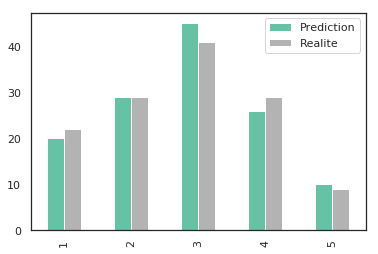

In [472]:
%matplotlib inline
fig = plt.figure(figsize=(12,9))
mypreds.plot(kind="bar", colormap="Set2")
fig.show()

Afin de mettre à l'épreuve la robustesse de notre modèle, nous allons essayer de déterminer les composés de pneus d'une course encore inconnue pour l'algorithme : le Grand Prix de Silverstone 2019.

In [511]:
silverstone = prepare_stint_dataset(1019)
silverstone = silverstone[['constructorForm', 'circuitId', 'compound', 'constructorPower', 'driverPerformance', 'race_completion', 'stint_avg_laptime', 'stint_duration']]
silverstone_labels = silverstone.pop('compound')
silverstone['circuitId'] = pd.Categorical(silverstone['circuitId'])
silverstone = pd.get_dummies(silverstone)
for c in circuits_1hot.columns:
    silverstone[c] = np.zeros(silverstone.shape[0])
silverstone
sil = silverstone.to_numpy()
sil_labels = silverstone_labels.to_numpy()

In [462]:
silverstone_predictions = myforest.predict(sil)

In [460]:
predsDict_silverstone = {'Realite':[0,0,0,0,0,0], 'Prediction':[0,0,0,0,0,0]}
silverstone_predictions = np.array(silverstone_predictions)
for i in range(0,5):
    predsDict_silverstone['Realite'][i+1] = np.sum(np.where(silverstone_labels == i+1, 1, 0))
    predsDict_silverstone['Prediction'][i+1] = np.sum(np.where(silverstone_predictions == i+1, 1, 0))
mypreds_silverstone = pd.DataFrame(predsDict_silverstone)
mypreds_silverstone = mypreds_silverstone.iloc[1:]
display(mypreds_silverstone)

,Prediction,Realite
1,0,12
2,28,20
3,19,17
4,2,0
5,0,0


<Figure size 864x648 with 0 Axes>

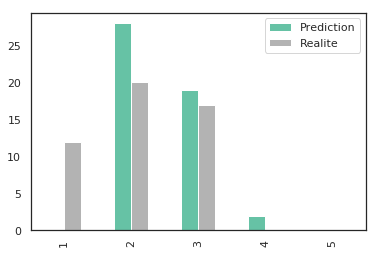

In [471]:
fig = plt.figure(figsize=(12,9))
mypreds_silverstone.plot(kind="bar", colormap="Set2")
fig.show()

On remarque que, comme le modèle n'a jamais été entraîné sur le circuit de Silverstone, il a un peu de mal à différencier les différents composés de pneus. Cela montre que le circuit joue un rôle primordial dans la performance des pneus. Afin d'obtenir une prédiction plus précise, il aurait fallu un dataset plus complet afin d'obtenir les informations de composés sur de nombreuses courses : il est en effet très laborieux de récolter ces données qui ne sont pas disponibles sur Internet.